<a href="https://colab.research.google.com/github/IaroslavS/blur_classification/blob/master/blur_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from skimage.io import imshow, show
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import pylab
import math
import numpy as np
from skimage.color import rgb2gray, gray2rgb
from tqdm import tqdm_notebook, tqdm
import pandas as pd
import cv2
import os
import PIL

In [0]:
IMAGE_DIMS = (512, 512, 1)
input_dir_images_for_blurring = '/content/drive/My Drive/Input_dir_images_for_blurring'
output_dir_images_for_blurring = '/content/drive/My Drive/Datasets/Dataset_of_clear_blurs_with_log'
dir_with_non_blurred_images = '/content/drive/My Drive/Images_from_COCO'
flag_look_for_spectres_instead_of_images = False
flag_make_log_pixels = True

##Определение функций ядра

In [0]:
def h_circular_scattering(x, y, param1=20, param2 = None, x_c = None, y_c = None):
  r = param1
  x = x - x_c
  y = y - y_c
  result = 0
  if (x*x + y*y) <= r*r:
    result = 1/(math.pi*(r*r))
  return result

def h_Gauss(x, y, C=1, param1=10, param2 = None, x_c = None, y_c = None):
  sigma = param1
  x = x - x_c
  y = y - y_c
  return (C * (math.e ** ( -(x**2 + y**2)/(2*(sigma**2))) ))

def h_linear_smearing(x,y, param1=32, param2 = 0, x_c = None, y_c = None):
  r = param1
  alpha = param2
  if abs(alpha) > 45: alpha = -math.copysign(90-abs(alpha), alpha)
  x = x - x_c
  y = -y + y_c
  D = r - (x**2 + y**2) ** 0.5
  distance_r = (x**2 + y**2) ** 0.5
  alpha = math.radians(alpha)
  result = 0
  if ( (x**2 + y**2) <= ((r**2)/4) ) and ( y == int(round(x*math.tan(alpha),0)) ):
    result = 1
#   elif (x**2 + y**2) <= ((r**2)/4) :
#     result = 1 - distance_r/D
  return result

##Формирование функции искажения по заданному изображению, виду искажения и параметрам ядра искажения

In [0]:
def blur(_image, kernel_blur, param1, param2):

  # создание отсчетов из ядра искажения---------------------------------------------------------------------------------
  v = np.zeros((_image.shape[0],_image.shape[1]))
  for i in range(_image.shape[0]):
    for j in range(_image.shape[1]):
      v[i][j] = kernel_blur(j, i, param1=param1, param2=param2, x_c = (_image.shape[1] // 2), y_c = (_image.shape[0] // 2))
  v = np.reshape(v,-1)
  v = v/np.sum(v) # Нормализуем матрицу отсчетов ядра искажения на единицу. Сумма элементов матрицы будет равна единице
  #----------------------------------------------------------------------------------------------------------------------
  
  #--------------------------------------------------------
  if (kernel_blur == h_linear_smearing) and (abs(param2) > 45):
    _image = np.transpose(_image[::-1])
  #--------------------------------------------------------

  #------Преобразование Фурье------------------------------
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  F_h = np.fft.fft(np.reshape(v,-1))
  #--------------------------------------------------------
  
  #--Берем только амплитуды у Фурье-образа изображения-----
  F_h = np.reshape(F_h, -1)
  for i in range(F_h.shape[-1]):
    F_h[i] = abs(F_h[i])
  #--------------------------------------------------------
  
  F = F_h*F_image # Перемножам Фурье-образ изображения с Фурье-образом ядра искажения
  f = np.fft.ifft(F) # Обратное преобразование Фурье
  f = np.reshape(f,_image.shape)
  
  if (kernel_blur == h_linear_smearing) and (abs(param2) > 45):
    f = np.transpose(f)[::-1]
  
  f_real = np.zeros(f.shape, dtype=float)
  for i in range(f.shape[0]):
    for j in range(f.shape[1]):
      f_real[i][j] = abs(f[i][j])
  return f_real

##Получение картинки амплитуды спектра размытого изображения

In [0]:
def get_pic_FT(_image):
  F_image = np.fft.fft(np.reshape(_image,(1,-1)))
  temp_F = np.copy(F_image)
  temp_F = np.reshape(temp_F, _image.shape)
  temp = np.zeros(temp_F.shape, dtype=float)
  temp = np.reshape(temp, _image.shape)
  for i in range(temp_F.shape[0]):
    k = i + temp_F.shape[0] // 2
    if k > (temp_F.shape[0]-1): k = i - temp_F.shape[0] // 2
    for j in range(temp_F.shape[1]):
      l = j + temp_F.shape[1] // 2
      if l > (temp_F.shape[1]-1): l = j - temp_F.shape[1] // 2
      temp[i][j] = abs(temp_F[k][l])
  return temp

#Создание датасета

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# The choice of blurrings: h_linear_smearing ,h_Gauss, h_circular_scattering
functions = [h_linear_smearing, h_Gauss, h_circular_scattering]

In [0]:
def blur_and_save_from_one_image(_image, _filename, make_log_pixels=False, look_for_spectres_instead_of_images=False):
  for function in functions: 
    num_images_for_one_blur = len(np.arange(2,int(_image.shape[0]*0.15)))
    fname = _filename[:_filename.rfind('.')]
    if function == h_linear_smearing: fname += '_linear smearing'
    elif function == h_circular_scattering: fname += '_circular scattering'
    elif function == h_Gauss: fname += '_Gauss'
    if function == h_circular_scattering:
      radiuses = np.arange(2,int(_image.shape[0]*0.15))
      param1 = radiuses
      param2 = None
    if function == h_Gauss:
      sigmas = np.linspace(0.1, 60, num_images_for_one_blur)
      param1 = sigmas
      param2 = None
    if function == h_linear_smearing:
      radiuses = np.linspace(2,_image.shape[0]*0.15, int(num_images_for_one_blur ** 0.5))
      alpha_upper = 90.0
      alpha_lower = -90.0
      alphas = np.linspace(alpha_lower, alpha_upper, int(num_images_for_one_blur ** 0.5))
      param1 = radiuses
      param2 = alphas
    for parameter_1 in param1:
    
      if type(param2) == type(np.arange(0.1,0.2,0.1)):
        for parameter_2 in param2:
          image_new = blur(_image, function, param1=parameter_1, param2=parameter_2)
          if look_for_spectres_instead_of_images: image_new = get_pic_FT(image_new)
          if make_log_pixels: 
            image_new = np.reshape(image_new,(-1))
            for i in range(len(image_new)):
              if image_new[i] != 0:
                image_new[i] = math.log(image_new[i])
            image_new = np.reshape(image_new,_image.shape)
          image_new = (image_new - np.min(image_new))/(np.max(image_new)-np.min(image_new))
          image_new = image_new*255
          image_output = image_new.astype(np.uint8)
          fname = _filename[:_filename.rfind('.')]
          if function == h_linear_smearing: fname += '_linear smearing'
          elif function == h_circular_scattering: fname += '_circular scattering'
          elif function == h_Gauss: fname += '_Gauss'
          fname += '_' + str(parameter_1) + '_' + str(parameter_2)
          array_to_file.append([fname+'.png', fname.split('_')[-3], fname.split('_')[-2], fname.split('_')[-1], _filename[:_filename.rfind('.')]])
          imsave(output_dir_images_for_blurring+'/'+_filename[:_filename.rfind('.')] +'/'+fname+'.png', image_output)
      elif type(param2) == type(None):
        image_new = blur(_image, function, param1=parameter_1, param2=None)
        if look_for_spectres_instead_of_images: image_new = get_pic_FT(image_new)
        if make_log_pixels: 
          image_new = np.reshape(image_new,(-1))
          for i in range(len(image_new)):
            if image_new[i] != 0:
              image_new[i] = math.log(image_new[i])
          image_new = np.reshape(image_new,_image.shape)
        image_new = (image_new - np.min(image_new))/(np.max(image_new)-np.min(image_new))
        image_new = image_new*255
        image_output = image_new.astype(np.uint8)
        fname = _filename[:_filename.rfind('.')]
        if function == h_linear_smearing: fname += '_linear smearing'
        elif function == h_circular_scattering: fname += '_circular scattering'
        elif function == h_Gauss: fname += '_Gauss'
        fname += '_' + str(parameter_1) + '_' + str(param2)
        array_to_file.append([fname+'.png', fname.split('_')[-3], fname.split('_')[-2], fname.split('_')[-1], _filename[:_filename.rfind('.')]])
        imsave(output_dir_images_for_blurring+'/'+_filename[:_filename.rfind('.')] +'/'+fname+'.png', image_output)

In [0]:
for filename in os.listdir(dir_with_non_blurred_images):
  if filename.find('None') == -1:
    os.rename(dir_with_non_blurred_images+'/'+filename, dir_with_non_blurred_images+'/'+filename.replace('_','-')[:filename.rfind('.')]+'_None_None_None'+filename[filename.rfind('.'):])

In [0]:
array_to_file = []
for filename in tqdm_notebook(os.listdir(input_dir_images_for_blurring)):
  if os.path.isdir(output_dir_images_for_blurring+'/'+filename[:filename.rfind('.')]) == False:
    os.mkdir(output_dir_images_for_blurring+'/'+filename[:filename.rfind('.')])
  image_PIL = PIL.Image.open(input_dir_images_for_blurring+'/'+filename).convert('RGB')
  image_PIL = image_PIL.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
  image_cv = np.array(image_PIL)
  image_gray = rgb2gray(image_cv)
  input_image_for_dataset = image_gray
  blur_and_save_from_one_image(input_image_for_dataset, filename, make_log_pixels=flag_make_log_pixels, 
                               look_for_spectres_instead_of_images=flag_look_for_spectres_instead_of_images)

In [0]:
if not(os.path.isdir(output_dir_images_for_blurring+'/Non-blurred-images')):
  os.mkdir(output_dir_images_for_blurring+'/Non-blurred-images')
for filename in tqdm_notebook(os.listdir(dir_with_non_blurred_images)):
  image_PIL = PIL.Image.open(dir_with_non_blurred_images+'/'+filename).convert('RGB')
  image_PIL = image_PIL.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
  image_cv = np.array(image_PIL)
  image_gray = rgb2gray(image_cv)
  image_new = np.copy(image_gray)
  if flag_look_for_spectres_instead_of_images:
    image_new = get_pic_FT(image_new)
  if flag_make_log_pixels:
    image_new = np.reshape(image_new,(-1))
    for i in range(len(image_new)):
      if image_new[i] != 0:
        image_new[i] = math.log(image_new[i])
    image_new = np.reshape(image_new,image_gray.shape)
  image_new = (image_new - np.min(image_new))/(np.max(image_new) - np.min(image_new))
  image_new = image_new*255
  image_new = image_new.astype('uint8')
  image_output = image_new
  imsave(output_dir_images_for_blurring+'/Non-blurred-images/'+filename, image_output)

In [0]:
# сохранение в csv файл 'dataset_csv'
pd.DataFrame(array_to_file).to_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv', index=False)

In [0]:
# Ищем изображения в папках, которые не занесены в файл .csv и записываем их в файл .csv
data_frame = pd.read_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv')
for dir_path_images in tqdm_notebook(os.listdir(output_dir_images_for_blurring)):
  if dir_path_images.find('.') == -1:
    for fname in os.listdir(output_dir_images_for_blurring+'/'+dir_path_images):
      if not (fname in [x for x in data_frame['0']]):
        a = []
        a += [fname]
        a += [fname.split('_')[-3]]
        a += [fname.split('_')[-2]]
        a += [fname.split('_')[-1]][:fname.rfind('.')]
        a += [dir_path_images]
        a = np.reshape(np.array(a), (1,-1))
        a = pd.DataFrame(a,columns=['0','1','2','3','4'])
        data_frame = pd.concat([data_frame, a])

# Удаляем те записи, по которым отсутствует фактически изображение
for i in range(len(data_frame)):
  flag = True
  for dir_path_images in os.listdir(output_dir_images_for_blurring):
    if dir_path_images.find('.') == -1:
      if os.listdir(output_dir_images_for_blurring+'/'+dir_path_images).count(data_frame.iloc[i][0]) != 0:
        flag = False
        break
  if flag:
    data_frame = data_frame.drop(index=i) 
      
# сохранение в csv файл 'dataset_csv'
data_frame = data_frame.sort_values(['1'])
pd.DataFrame(data_frame).to_csv(output_dir_images_for_blurring+'/'+'dataset_csv'+'.csv', index=False)

# Обучение модели

In [2]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from PIL import Image

from keras import backend as K

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Here we copy files from directory with blurred images and copy them to directory, where model will take images for training
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images'

In [0]:
EPOCHS = 100
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1) 

In [0]:
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

In [0]:
for i in range(len(train_dataframe)):
  train_dataframe.iloc[i,0] = train_dataframe.iloc[i,4]+'/'+train_dataframe.iloc[i,0]
for i in range(len(test_dataframe)):
  test_dataframe.iloc[i,0] = test_dataframe.iloc[i,4]+'/'+test_dataframe.iloc[i,0]

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x
  
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def ResNet50(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [10]:
resnet50_model = ResNet50(input_tensor=None, input_shape=None,
             pooling=None,
             classes=4)

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet50_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

Found 2261 validated image filenames belonging to 4 classes.
Found 566 validated image filenames belonging to 4 classes.


In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet50-blur-classification-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Results of training on blurred images from 10 original images

In [0]:
H = resnet50_model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                                 validation_data=(testX, testY),
                                 steps_per_epoch=len(trainX) // BS,
                                 epochs=EPOCHS,
                                 verbose=1)



Epoch 1/100
53/53 [==============================] - 76s 1s/step - loss: 0.7380 - acc: 0.6154 - val_loss: 0.8152 - val_acc: 0.6415
Epoch 2/100
53/53 [==============================] - 52s 982ms/step - loss: 0.6289 - acc: 0.6733 - val_loss: 0.6900 - val_acc: 0.6533
Epoch 3/100
53/53 [==============================] - 52s 982ms/step - loss: 0.5919 - acc: 0.6965 - val_loss: 0.6448 - val_acc: 0.6800
Epoch 4/100
53/53 [==============================] - 52s 980ms/step - loss: 0.5868 - acc: 0.6973 - val_loss: 0.6058 - val_acc: 0.6973
Epoch 5/100
53/53 [==============================] - 52s 977ms/step - loss: 0.5766 - acc: 0.6983 - val_loss: 0.5835 - val_acc: 0.6965
Epoch 6/100
53/53 [==============================] - 52s 981ms/step - loss: 0.5656 - acc: 0.7018 - val_loss: 0.5778 - val_acc: 0.6910
Epoch 7/100
53/53 [==============================] - 52s 979ms/step - loss: 0.5615 - acc: 0.7032 - val_loss: 0.5648 - val_acc: 0.6973
Epoch 8/100
53/53 [==============================] - 52s 981ms/

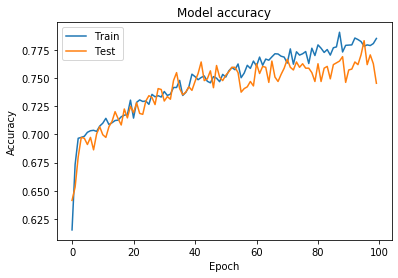

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

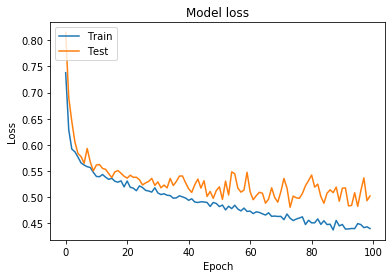

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
H.history['val_acc'][np.argmin(H.history['val_loss'])]

0.7641509636393133

# Training on spectres of blurred images

In [2]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import cv2
from sklearn.utils import shuffle
from keras.preprocessing.image import img_to_array
import numpy as np
from skimage.color import rgb2gray, gray2rgb
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


import math
from keras.optimizers import Adam, SGD

import shutil

from keras.callbacks import ModelCheckpoint

import numpy as np
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from PIL import Image

from keras import backend as K

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_with_blurred_images = '/content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images'

In [0]:
EPOCHS = 200
INIT_LR = 1e-5 # initial learning rate
BS = 64 # batch size
IMAGE_DIMS = (512, 512, 1) 

In [0]:
dataframe = pd.read_csv(dir_with_blurred_images+'/dataset_csv.csv')

In [0]:
fraction_of_train_set = 0.8
result_test_dataframe = pd.DataFrame({})
result_train_dataframe = pd.DataFrame({})
for label in np.unique(np.array(dataframe.iloc[:,1].tolist())):
  dataframe_labeled = dataframe.loc[dataframe['1']==label]
  number_of_samples = fraction_of_train_set*len(dataframe_labeled)
  indexes_for_train = random.sample(list(dataframe_labeled.index), int(number_of_samples))
  train_dataframe = dataframe_labeled.loc[indexes_for_train]
  test_dataframe = dataframe_labeled.copy()
  for index in indexes_for_train:
    test_dataframe = test_dataframe.drop(index)
  result_test_dataframe = pd.concat([result_test_dataframe,test_dataframe])
  result_train_dataframe = pd.concat([result_train_dataframe, train_dataframe])
test_dataframe = result_test_dataframe.copy()
train_dataframe = result_train_dataframe.copy()

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x
  
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def ResNet50_for_spectres(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [0]:
resnet50_model_for_spectres = ResNet50_for_spectres(input_tensor=None, input_shape=None,
             pooling=None,
             classes=4)

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
resnet50_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_df = train_dataframe
valid_df = test_dataframe

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=dir_with_blurred_images,
        x_col="0",
        y_col="1",
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical')

In [0]:
filepath_model_to_save = dir_with_blurred_images+'/weights-resnet50-blur-classification-spectres-of-images-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath_model_to_save, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
H=resnet50_model.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(len(train_df) / BS),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=math.ceil(len(valid_df) / BS),
        verbose=1,
        callbacks = callbacks_list)



Epoch 1/100
71/71 [==============================] - 719s 10s/step - loss: 0.5539 - acc: 0.7534 - val_loss: 0.4904 - val_acc: 0.7725

Epoch 00001: val_acc improved from -inf to 0.77253, saving model to /content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images/weights-resnet50-blur-classification-01-0.77.hdf5
Epoch 2/100
71/71 [==============================] - 71s 1s/step - loss: 0.4796 - acc: 0.7845 - val_loss: 0.4411 - val_acc: 0.7946

Epoch 00002: val_acc improved from 0.77253 to 0.79461, saving model to /content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images/weights-resnet50-blur-classification-02-0.79.hdf5
Epoch 3/100
71/71 [==============================] - 71s 998ms/step - loss: 0.4302 - acc: 0.8099 - val_loss: 0.4241 - val_acc: 0.7977

Epoch 00003: val_acc improved from 0.79461 to 0.79770, saving model to /content/drive/My Drive/Datasets/Dataset_of_spectres_of_blurred_images/weights-resnet50-blur-classification-03-0.80.hdf5
Epoch 4/100
71/71 [=====

In [1]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

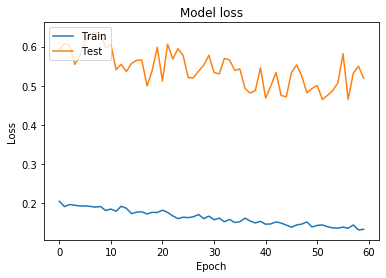

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.max(H.history['val_acc'])

0.8405477021271264

# Results of training on clear blur with log

In [0]:
H = resnet50_model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                                 validation_data=(testX, testY),
                                 steps_per_epoch=len(trainX) // BS,
                                 epochs=EPOCHS,
                                 verbose=1,
                                 callbacks = callbacks_list)

Epoch 1/100
5/5 [==============================] - 5s 1s/step - loss: 0.3768 - acc: 0.8319 - val_loss: 0.6314 - val_acc: 0.7597

Epoch 00001: val_acc did not improve from 0.78295
Epoch 2/100
5/5 [==============================] - 5s 919ms/step - loss: 0.3957 - acc: 0.8409 - val_loss: 0.6150 - val_acc: 0.7597

Epoch 00002: val_acc did not improve from 0.78295
Epoch 3/100
5/5 [==============================] - 5s 916ms/step - loss: 0.3382 - acc: 0.8710 - val_loss: 0.5984 - val_acc: 0.7829

Epoch 00003: val_acc improved from 0.78295 to 0.78295, saving model to /content/drive/My Drive/Datasets/Dataset_of_clear_blurs_with_log/weights-resnet50-blur-classification-03-0.78.hdf5
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 0.3745 - acc: 0.8229 - val_loss: 0.5941 - val_acc: 0.7829

Epoch 00004: val_acc did not improve from 0.78295
Epoch 5/100
5/5 [==============================] - 4s 830ms/step - loss: 0.3952 - acc: 0.8400 - val_loss: 0.5930 - val_acc: 0.7829

Epoch 0000

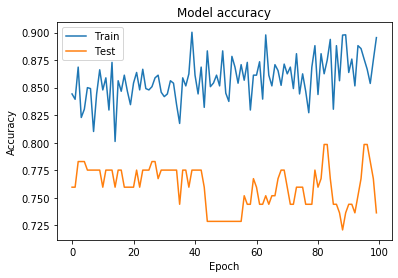

In [0]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

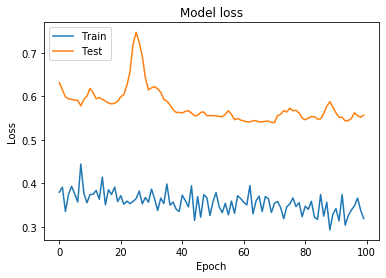

In [0]:
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
H.history['val_acc'][np.argmin(H.history['val_loss'])]

0.7596899368042169

# Checking model on custom images

In [0]:
from keras.models import load_model

In [0]:
model = load_model('/content/drive/My Drive/weights/After_training_on_clear_blur/weights-resnet50-blur-classification-64-0.97.hdf5')

In [0]:
total_num = 0
num_of_success = 0
dir_for_test_images = '/content/drive/My Drive/Dataset_blured_images'
for dir in os.listdir(dir_for_test_images):
  if dir.find('.') == -1:
    print('Processing directory \''+ dir+'\'', flush=True)
    for filename in os.listdir(dir_for_test_images+'/'+dir):
      image_PIL = PIL.Image.open(dir_for_test_images+'/'+dir+'/'+filename).convert('RGB')
      image_PIL = image_PIL.resize((224,224))
      image_cv = np.array(image_PIL)
      image_cv_4_dim = np.expand_dims(image_cv, axis=0)
      input_image_for_dataset = image_cv_4_dim
      prediction = model.predict(input_image_for_dataset)
      class_predicted = mlb.classes_[[prediction == np.max(prediction[0])][0][0]][0]
      total_num += 1
      if class_predicted == filename.split('_')[-3]:
        num_of_success += 1
        print(dir)
        print(class_predicted)
print('accuracy = '+str(num_of_success/total_num))

In [0]:
num_of_success

148